## Brain Tumor Classification

Dataset Source: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

#### Import Necessary Libraries

In [1]:
import os, sys, glob
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, ClassLabel, DatasetDict

import transformers
from transformers import TrainingArguments, AutoFeatureExtractor
from transformers import AutoModelForImageClassification, Trainer

import torch

import evaluate

!git lfs install

Git LFS initialized.


#### Display Versions of Relevant Libraries

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.24.3
        Pandas: 2.0.1
      Datasets: 2.11.0
  Transformers: 4.28.1
         Torch: 2.0.0


#### Convert Label Values From String to Integer

In [3]:
labels = ['glioma_tumor', 
          'meningioma_tumor', 
          'no_tumor', 
          'pituitary_tumor'
          ]

NUM_OF_LABELS = len(labels)

id2label = {str(i): str(c) for i, c in enumerate(labels)}
label2id = {str(c): str(i) for i, c in enumerate(labels)}

print(label2id)
print(id2label)

{'glioma_tumor': '0', 'meningioma_tumor': '1', 'no_tumor': '2', 'pituitary_tumor': '3'}
{'0': 'glioma_tumor', '1': 'meningioma_tumor', '2': 'no_tumor', '3': 'pituitary_tumor'}


#### Create Metadata File for Training Dataset

In [4]:
train_files_list = glob.glob("/Users/briandunn/Desktop/Image Classification Comparison/data/Training/*/*.jpg")

train_df = pd.DataFrame(train_files_list, columns=["file_name"])

train_df['label'] = train_df['file_name'].apply(lambda x: x.split("/")[-2])

train_df['label'] = train_df['label'].replace(label2id)

train_df['file_name'] = train_df['file_name'].apply(lambda x: x.split("Training/")[-1])

train_df.to_csv("/Users/briandunn/Desktop/Image Classification Comparison/data/Training/metadata.csv")

#### Ingest Training Dataset

In [5]:
train_dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/Image Classification Comparison/data/Training",
                        split='train')

train_dataset = train_dataset.remove_columns('Unnamed: 0')
train_dataset = train_dataset.cast_column("label", ClassLabel(names=[0, 1, 2, 3]))

train_dataset

Resolving data files:   0%|          | 0/2871 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-19722e489888cf11/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Casting the dataset:   0%|          | 0/2870 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 2870
})

#### Create Metadata File for Testing Dataset

In [6]:
test_files_list = glob.glob("/Users/briandunn/Desktop/Image Classification Comparison/data/Testing/*/*.jpg")

test_df = pd.DataFrame(test_files_list, columns=["file_name"])

test_df['label'] = test_df['file_name'].apply(lambda x: x.split("/")[-2])

test_df['label'] = test_df['label'].replace(label2id)

test_df['file_name'] = test_df['file_name'].apply(lambda x: x.split("Testing/")[-1])

test_df.to_csv("/Users/briandunn/Desktop/Image Classification Comparison/data/Testing/metadata.csv")

#### Ingest Testing Dataset

In [7]:
test_dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/Image Classification Comparison/data/Testing",
                        split='train')

test_dataset = test_dataset.remove_columns('Unnamed: 0')
test_dataset = test_dataset.cast_column("label", ClassLabel(names=[0, 1, 2, 3]))

test_dataset

Resolving data files:   0%|          | 0/395 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-4035a4a61d10531b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Casting the dataset:   0%|          | 0/394 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 394
})

#### Combine Training & Testing Datasets into DatasetDict

In [8]:
ds = DatasetDict({
    'train' : train_dataset,
    'test' : test_dataset
})

#### Some Information About Train & Test Datasets

In [9]:
print("Training Dataset")
print(ds['train'])
print(ds['train'][0])
print(ds['train'][-1])
print(ds['train'].unique("label"))

print("\nTesting Dataset")
print(ds['test'])
print(ds['test'][0])
print(ds['test'][-1])
print(ds['test'].unique("label"))

Training Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 2870
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FBD1A1D7940>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FBD1A1DBBE0>, 'label': 3}
[0, 1, 2, 3]

Testing Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 394
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=495x619 at 0x7FBD1A1DB850>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FBD1A1DB4C0>, 'label': 3}
[0, 1, 2, 3]


#### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [10]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = train_dataset.features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, id2label[str(label)], (255, 255, 255), font=font, dill=(0,0,255,1.0))
    
    return grid

Filter:   0%|          | 0/2870 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2870 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2870 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2870 [00:00<?, ? examples/s]

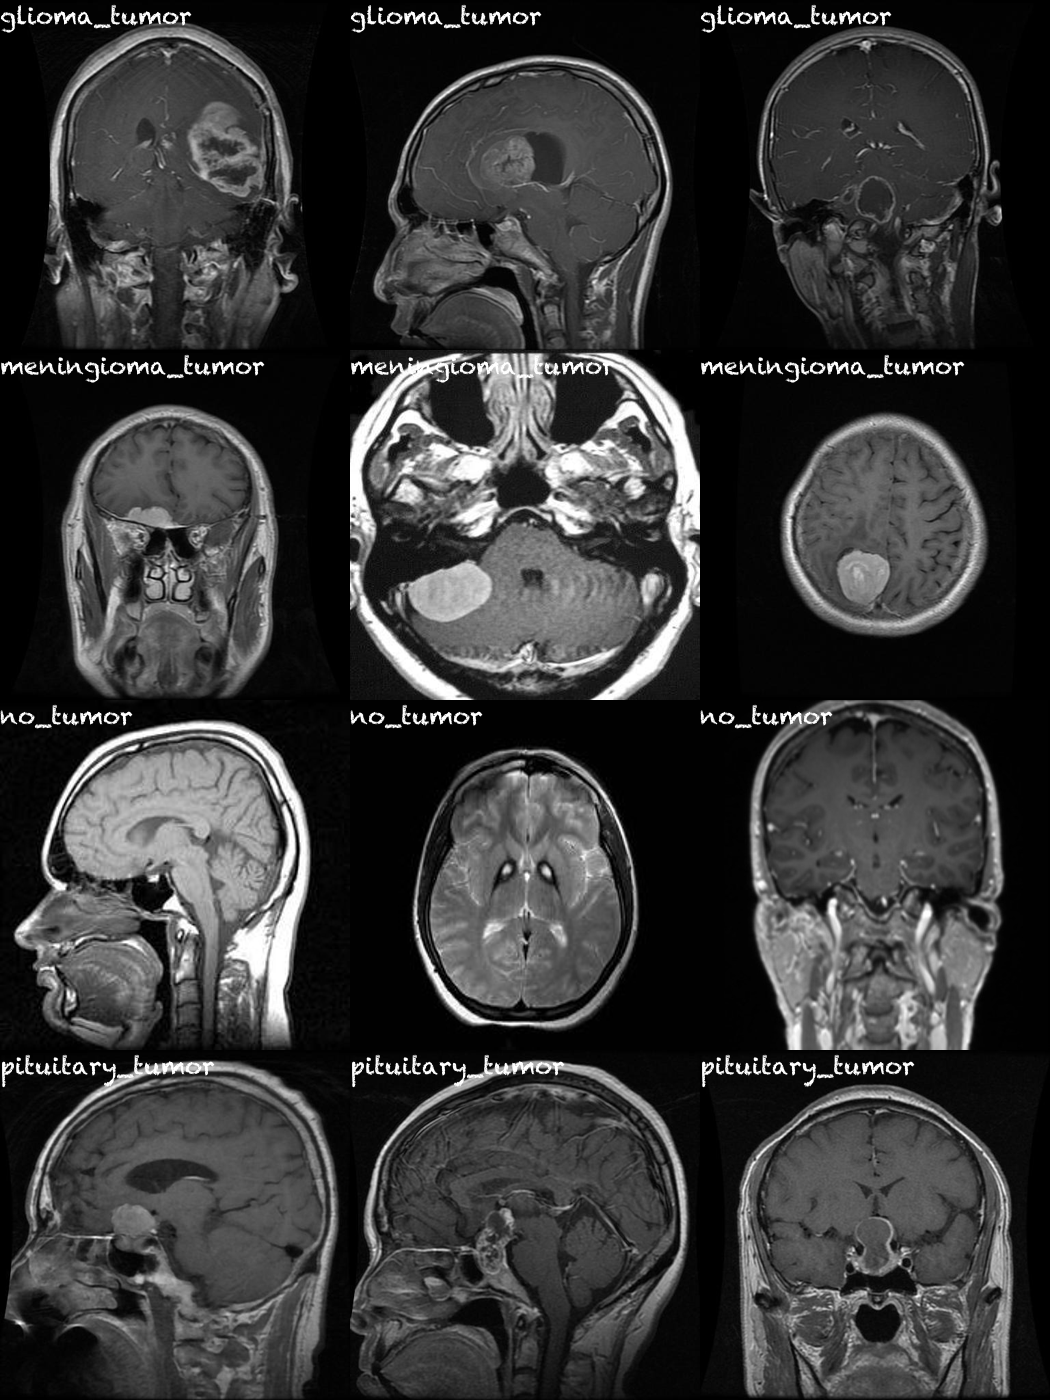

In [11]:
show_grid_of_examples(ds, seed=42, examples_per_class=3)

#### Basic Values/Constants

In [12]:
MODEL_CKPT = 'facebook/vit-msn-base'
NUM_OF_EPOCHS = 3

LEARNING_RATE = 2e-4
STEPS = 100

BATCH_SIZE = 16
DEVICE = torch.device("mps")

REPORTS_TO ='tensorboard'

#### Load ViT Feature Extractor

In [13]:
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CKPT)

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


#### Preprocessing Dataset

In [14]:
def transform(sample_batch):
    # take list of PIL images & turn them into pixel values
    inputs = feature_extractor([x.convert("RGB") for x in sample_batch['image']], return_tensors="pt")
    
    # prepare labels
    inputs['labels'] = sample_batch['label']
    return inputs

#### Apply Transform Function to Dataset

In [15]:
prepped_ds = ds.with_transform(transform)

#### Define Data Collator

In [16]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

#### Define Evaluation Metric

In [17]:
def compute_metrics(p):
    """
    This function takes the predictions output from 
    trainer.evaluate & returns metrics (accuracy, F1, 
    recall, & precision) for a multiclass 
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, 
                                                             axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                      axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]
    
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']
    
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                                  axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]
    
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]
    
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                        axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
    
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]
    
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Load Pretrained Model

In [18]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id
).to(DEVICE)

Some weights of ViTMSNForImageClassification were not initialized from the model checkpoint at facebook/vit-msn-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [19]:
args = TrainingArguments(
    output_dir=MODEL_CKPT.split("/")[-1] + "-Brain_Tumors_Image_Classification",
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    load_best_model_at_end=True,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Subclass Trainer to Handle Class Imbalance

In [20]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0, 4.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [21]:
trainer = CustomTrainer(
    model = model,
    args= args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset=prepped_ds['train'],
    eval_dataset=prepped_ds['test'],
    tokenizer=feature_extractor,
)

Cloning https://huggingface.co/DunnBC22/vit-msn-base-Brain_Tumors_Image_Classification into local empty directory.


#### Train Model

In [22]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/540 [00:00<?, ?it/s]

{'loss': 4.3487, 'learning_rate': 0.00019962962962962963, 'epoch': 0.01}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 2.891019344329834, 'eval_accuracy': 0.43908629441624364, 'eval_Weighted F1': 0.39030198127926613, 'eval_Micro F1': 0.4390862944162436, 'eval_Macro F1': 0.3969878121241106, 'eval_Weighted Recall': 0.43908629441624364, 'eval_Micro Recall': 0.43908629441624364, 'eval_Macro Recall': 0.4303704325443456, 'eval_Weighted Precision': 0.661679110658221, 'eval_Micro Precision': 0.43908629441624364, 'eval_Macro Precision': 0.6966439487814953, 'eval_runtime': 128.047, 'eval_samples_per_second': 3.077, 'eval_steps_per_second': 0.39, 'epoch': 1.0}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.7744580507278442, 'eval_accuracy': 0.7030456852791879, 'eval_Weighted F1': 0.665373503844381, 'eval_Micro F1': 0.7030456852791879, 'eval_Macro F1': 0.6623317740210306, 'eval_Weighted Recall': 0.7030456852791879, 'eval_Micro Recall': 0.7030456852791879, 'eval_Macro Recall': 0.683543590174025, 'eval_Weighted Precision': 0.7491108404398296, 'eval_Micro Precision': 0.7030456852791879, 'eval_Macro Precision': 0.7588421776256589, 'eval_runtime': 128.5185, 'eval_samples_per_second': 3.066, 'eval_steps_per_second': 0.389, 'epoch': 2.0}
{'loss': 0.362, 'learning_rate': 1.4814814814814815e-05, 'epoch': 2.78}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.810570240020752, 'eval_accuracy': 0.7690355329949239, 'eval_Weighted F1': 0.7306148585114326, 'eval_Micro F1': 0.7690355329949239, 'eval_Macro F1': 0.7347369623851575, 'eval_Weighted Recall': 0.7690355329949239, 'eval_Micro Recall': 0.7690355329949239, 'eval_Macro Recall': 0.7587720329024678, 'eval_Weighted Precision': 0.8325757810243077, 'eval_Micro Precision': 0.7690355329949239, 'eval_Macro Precision': 0.8477388211382114, 'eval_runtime': 127.9819, 'eval_samples_per_second': 3.079, 'eval_steps_per_second': 0.391, 'epoch': 3.0}
{'train_runtime': 8073.8261, 'train_samples_per_second': 1.066, 'train_steps_per_second': 0.067, 'train_loss': 0.34402430885367924, 'epoch': 3.0}


#### Save Model & Metrics

In [23]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file runs/Jun09_00-52-00_Brians-Mac-mini/events.out.tfevents.1686289925.Brians-Mac-mini.11253.0:   0%| …

To https://huggingface.co/DunnBC22/vit-msn-base-Brain_Tumors_Image_Classification
   72a68a7..fa16be8  main -> main

To https://huggingface.co/DunnBC22/vit-msn-base-Brain_Tumors_Image_Classification
   fa16be8..1460d0c  main -> main



***** train metrics *****
  epoch                    =        3.0
  train_loss               =      0.344
  train_runtime            = 2:14:33.82
  train_samples_per_second =      1.066
  train_steps_per_second   =      0.067


#### Push Model to Hub (My Profile!)

In [24]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

To https://huggingface.co/DunnBC22/vit-msn-base-Brain_Tumors_Image_Classification
   1460d0c..add3f9c  main -> main



## Notes & Other Takeaways From This Project

****
- This project is part of a comparison of many transformers using this same dataset.
- This project did not quite live up to the results of the ViT transformer.

****

### Citation

- Model Checkpoint

    > @article{assran2022masked, title={Masked Siamese Networks for Label-Efficient Learning}, author={Assran, Mahmoud, and Caron, Mathilde, and Misra, Ishan, and Bojanowski, Piotr, and Bordes, Florian and Vincent, Pascal, and Joulin, Armand, and Rabbat, Michael, and Ballas, Nicolas}, journal={arXiv preprint arXiv:2204.07141}, year={2022}}
